# Background modelling: min_dR

**Goal:** Let's test the *non-closure* in the CR and VR for these VR templates - maybe comparing to some measure of pulls or signficances?


I *also* was curious to see if $H_T$ or quadrant splits were necessary rn.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr, L

from statUtils import calc_bstrap

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
yr = 17
mc = 'mc16d'

In [4]:
x1,y1 = 124,117

In [5]:
rw_cols = ['njets','pT_4','pT_2','dRjj_1','dRjj_2','eta_i','pt_hh','X_wt_tag','m_hh',
           'HT', 'dPhi_h1', 'dPhi_h2', 'dRjj_h1', 'dRjj_h2','dR_hh']

load_cols = ['dEta_hh','phi_h1','phi_h2','pass_vbf_sel'] 
load_cols += [f'{v}_h{i}_j{j}' for v,i,j in product(['pT','eta','phi'],[1,2],[1,2])]

In [6]:
wcols = [f'NN_d24_weight_bstrap_med_{yr}',
         f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
         f'NN_d24_weight_bstrap_IQR_{yr}']

cols = ['ntag'] + rw_cols[:9] + load_cols + wcols

In [9]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind'
rwTag = f'_min_dR_VEC_sr_{x1}_{y1}_NN_100_bootstraps'

with uproot.open(f'{fDir}/data{yr}{rwTag}.root') as f:

    try:

        # uproot3 syntax
        sr = f['sig'].pandas.df(cols)
        vr = f['validation'].pandas.df(cols)
        cr = f['control'].pandas.df(cols)

        norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
        norm_VR  = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal
        norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal
               
    except:
        
        # uproot4 syntax
        sr = f['sig'].arrays(cols,library='pd')
        vr = f['validation'].arrays(cols,library='pd')
        cr = f['control'].arrays(cols,library='pd')   
        
        norm     = f[f'NN_norm_bstrap_med_{yr}'].all_members['fVal']
        norm_VR  = f[f'NN_norm_VRderiv_bstrap_med_{yr}'].all_members['fVal']
        norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}'].all_members['fVal']
        
for bdf in [sr,vr,cr]:
    bdf['w_2b'] = norm * bdf[f'NN_d24_weight_bstrap_med_{yr}']
    bdf['w_2b_VR'] = norm_VR * bdf[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

#f.close()

**Next:** Let's load in $t\bar{t}$ to _also_ include it on these plots!

Note - I ran these samples w/ the shifted SR, i.e, an SR center of (124,117), so the `kinematic_region` can be used here for accessing the analysis regions .

In [10]:
rrDir = '../../hh4b/hh4b-resolved-reconstruction/'
tName = 'fullmassplane'

tcols = ['ntag','mc_sf','m_h1','m_h2','kinematic_region'] + rw_cols[:9] + load_cols 

try:
    ah = uproot.open(f'{rrDir}/allhad_{mc}_merge.root')[tName].pandas.df(tcols)
    sl = uproot.open(f'{rrDir}/semilep_{mc}_merge.root')[tName].pandas.df(tcols)

except:
    ah = uproot.open(f'{rrDir}/allhad_{mc}_merge.root')[tName].arrays(tcols,library='pd')
    sl = uproot.open(f'{rrDir}/semilep_{mc}_merge.root')[tName].arrays(tcols,library='pd')


assert mcToYr[mc] == yr+2000

for df in [ah,sl]:
    df['mc_sf'] *= L[yr]

ah = ah[(~ah.pass_vbf_sel) & (ah.kinematic_region <=2)]
sl = sl[(~sl.pass_vbf_sel) & (sl.kinematic_region <=2)]

**Make a little motivation table for the % of $t\bar{t}$ in our regions**

In [28]:
idx = ['SR','VR','CR']
ycols = ['2b','3b','4b','rw 2b']
ycols += [f'{ps} {ntag}b' for ps, ntag in product(['allhad','semilep'],[2,3,4])]

yields = pd.DataFrame(0,idx,ycols)

# Then also get these metrics broken down into 3 deta_hh cats
eta_edgs = np.linspace(0,1.5,4)
y_dict = { f'{emin},{emax}':pd.DataFrame(0,idx,ycols) 
           for emin, emax in zip(eta_edgs[:-1], eta_edgs[1:]) }


In [29]:
yields

2b  3b  4b  rw 2b  allhad 2b  allhad 3b  allhad 4b  semilep 2b  \
SR   0   0   0      0          0          0          0           0   
VR   0   0   0      0          0          0          0           0   
CR   0   0   0      0          0          0          0           0   

    semilep 3b  semilep 4b  
SR           0           0  
VR           0           0  
CR           0           0

In [55]:
# Fill the data cols
for region,df in zip(idx,[sr,vr,cr]):
    for ntag in [2,3,4]:
        
        if ntag == 4:
            m = (df.ntag >= 4)
        else:
            m = (df.ntag == ntag)

        if ntag == 2: 
            yields.loc[region,f'rw {ntag}b'] = df.loc[m,'w_2b'].sum()
            
            for emin, emax in zip(eta_edgs[:-1], eta_edgs[1:]):
                mi = m & (df.dEta_hh > emin) & (df.dEta_hh < emax)
                y_dict[f'{emin},{emax}'].loc[region,f'rw {ntag}b'] = df.loc[mi,'w_2b'].sum()
            
            
        if (ntag > 2) & (region=='SR'):
            print("Don't unblind - skip 4b / 3b SR yeild!")
            continue
            
            
        yields.loc[region,f'{ntag}b'] = np.sum(m)

        for emin, emax in zip(eta_edgs[:-1], eta_edgs[1:]):
            mi = m & (df.dEta_hh > emin) & (df.dEta_hh < emax)
            y_dict[f'{emin},{emax}'].loc[region,f'{ntag}b'] = np.sum(mi)



Don't unblind - skip 4b / 3b SR yeild!
Don't unblind - skip 4b / 3b SR yeild!


In [50]:
# Fill the ttbar cols
for ps, df in zip(['allhad','semilep'],[ah,sl]):
    
    for r, region in enumerate(idx):
                
        for ntag in [2,3,4]:
        
            if ntag == 4:
                m = (df.kinematic_region == r) & (df.ntag >= 4)
            else:
                m = (df.kinematic_region == r) & (df.ntag == ntag)
              
            #print(f'{ps} {ntag}b')
            yields.loc[region,f'{ps} {ntag}b'] = df.loc[m,'mc_sf'].sum()
            
            for emin, emax in zip(eta_edgs[:-1], eta_edgs[1:]):
                mi = m & (df.dEta_hh > emin) & (df.dEta_hh < emax)
                y_dict[f'{emin},{emax}'].loc[region,f'{ps} {ntag}b'] = df.loc[mi,'mc_sf'].sum()


In [15]:
yields.round(1)

2b    3b     4b    rw 2b  allhad 2b  allhad 3b  allhad 4b  semilep 2b  \
SR  346329  3957      0   4203.6    44077.5      591.2      275.8     24415.6   
VR  438412  4972   5945   5583.9    47076.1      665.8      306.6     27628.0   
CR  875295  9929  11838  11838.0    72825.2     1012.2      523.2     46291.2   

    semilep 3b  semilep 4b  
SR       226.2       110.7  
VR       281.2       134.6  
CR       483.7       239.8

In [36]:
for ntag,region in product([2,3,4],['SR','VR','CR']):
    yields.loc[region,f'ttbar {ntag}b'] = yields.loc[region,f'allhad {ntag}b']+ yields.loc[region,f'semilep {ntag}b']
    
    for k in y_dict.keys():
        y_dict[k].loc[region,f'ttbar {ntag}b'] = y_dict[k].loc[region,f'allhad {ntag}b']+ y_dict[k].loc[region,f'semilep {ntag}b']
    

In [37]:
for ps in ['allhad','semilep','ttbar']:
    yields[f'{ps} 4b / 2b'] = yields[f'{ps} 4b'] / yields[f'{ps} 2b']
    
    for k in y_dict.keys():
        y_dict[k][f'{ps} 4b / 2b'] = y_dict[k][f'{ps} 4b'] / y_dict[k][f'{ps} 2b']
    

In [38]:
yields['4b / 2b'] = yields['4b'] / yields['2b']

In [39]:
yields[[f'{ps}4b / 2b' for ps in ['','ttbar ','allhad ','semilep ']]]*100

4b / 2b  ttbar 4b / 2b  allhad 4b / 2b  semilep 4b / 2b
SR  0.000000       0.564368        0.625747         0.453560
VR  1.356030       0.590589        0.651340         0.487074
CR  1.352458       0.640543        0.718394         0.518068

In [58]:
for ps in ['allhad','semilep','ttbar']:
    yields[f'{ps} 4b / data 4b'] = yields[f'{ps} 4b'] / yields['4b']
    yields[f'{ps} 4b / rw 2b'] = yields[f'{ps} 4b'] / yields['rw 2b']
    
    for k in y_dict.keys():
        y_dict[k][f'{ps} 4b / data 4b'] = y_dict[k][f'{ps} 4b'] / y_dict[k]['4b']
        y_dict[k][f'{ps} 4b / rw 2b'] = y_dict[k][f'{ps} 4b'] / y_dict[k]['rw 2b']

In [21]:
100*yields[[f'{ps} 4b / {den}' for ps,den in product(['ttbar','allhad','semilep'],['data 4b','rw 2b'])]].round(5)

ttbar 4b / data 4b  ttbar 4b / rw 2b  allhad 4b / data 4b  \
SR                 inf             9.196                  inf   
VR               7.421             7.901                5.158   
CR               6.445             6.445                4.419   

    allhad 4b / rw 2b  semilep 4b / data 4b  semilep 4b / rw 2b  
SR              6.561                   inf               2.634  
VR              5.491                 2.264               2.410  
CR              4.419                 2.026               2.026

In [56]:
y_dict['0.0,0.5']

2b    3b    4b        rw 2b     allhad 2b   allhad 3b   allhad 4b  \
SR  120975     0     0  1440.920402  17221.119141  216.347244  104.335938   
VR  153555  1706  2016  1953.554618  18478.808594  254.065887  111.196732   
CR  305583  3480  4097  4156.217753  28933.144531  380.964355  199.264801   

      semilep 2b  semilep 3b  semilep 4b  ...      ttbar 2b    ttbar 3b  \
SR   9367.362305   84.954727   39.919769  ...  26588.481445  301.301971   
VR  10652.072266  104.338440   52.200684  ...  29130.880859  358.404327   
CR  18093.761719  181.044769   87.332535  ...  47026.906250  562.009125   

      ttbar 4b  ttbar 4b / 2b  allhad 4b / rw 2b  semilep 4b / rw 2b  \
SR  144.255707       0.005425           0.000862            0.000330   
VR  163.397415       0.005609           0.000724            0.000340   
CR  286.597336       0.006094           0.000652            0.000286   

    ttbar 4b / rw 2b  allhad 4b / data 4b  semilep 4b / data 4b  \
SR          0.001192                  inf                   inf   
VR          0.001064                  inf                   inf   
CR          0.000938                  inf                   inf   

    ttbar 4b / data 4b  
SR                 inf  
VR                 inf  
CR                 inf  

[3 rows x 24 columns]

In [60]:
k = '0.0,0.5'
print(k)
100*y_dict[k][[f'ttbar 4b / {den}' for den in ['data 4b','rw 2b']]].round(5)

0.0,0.5


ttbar 4b / data 4b  ttbar 4b / rw 2b
SR                 inf            10.011
VR               8.105             8.364
CR               6.995             6.896

In [61]:
k = '0.5,1.0'
print(k)
100*y_dict[k][[f'ttbar 4b / {den}' for den in ['data 4b','rw 2b']]].round(5)

0.5,1.0


ttbar 4b / data 4b  ttbar 4b / rw 2b
SR                 inf             9.007
VR               7.653             8.385
CR               6.723             6.635

In [62]:
k = '1.0,1.5'
print(k)
100*y_dict[k][[f'ttbar 4b / {den}' for den in ['data 4b','rw 2b']]].round(5)

1.0,1.5


ttbar 4b / data 4b  ttbar 4b / rw 2b
SR                 inf             8.516
VR               6.433             6.870
CR               5.557             5.727

In [22]:
for df in [sr,vr,cr,ah,sl]:

    df['HT'] = np.sum(df[[f'pT_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
    
    df['dPhi_hh'] = np.arccos(np.cos(df.phi_h1 - df.phi_h2))
    df['dPhi_h1'] = np.arccos(np.cos(df.phi_h1_j1 - df.phi_h1_j2))
    df['dPhi_h2'] = np.arccos(np.cos(df.phi_h2_j1 - df.phi_h2_j2))
    
    df['dR_hh'] = np.sqrt(df.dEta_hh**2+df.dPhi_hh**2)
    df['dRjj_h1'] = np.sqrt((df.eta_h1_j1-df.eta_h1_j2)**2+df.dPhi_h1**2)
    df['dRjj_h2'] = np.sqrt((df.eta_h2_j1-df.eta_h2_j2)**2+df.dPhi_h2**2)
    

In [23]:
ti = "$\mathbf{ATLAS}$ Simulation Internal\n"
ti += f"{mc}, MAR MNT\n"
ti += "min_dR, X_wt_tag, res bkts"

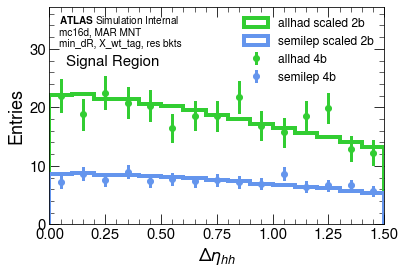

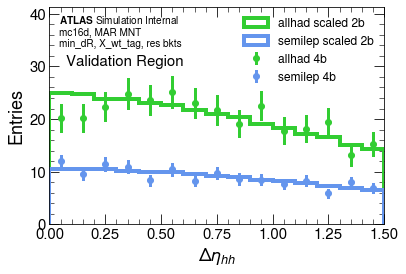

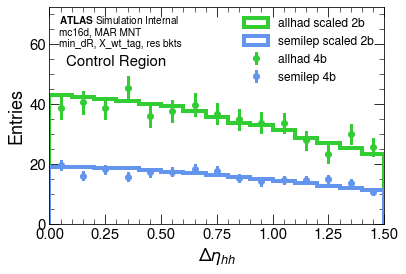

In [24]:
n,r = 15, (0,1.5)

for i,region,t in zip(range(3),['SR','VR','CR'],['Signal','Validation','Control']):
    
    plt.figure()
    for ps,df,c in zip(['allhad','semilep'],[ah,sl],['limegreen','cornflowerblue']):

        m_2b = (df.kinematic_region==i) & (df.ntag==2)
        m_4b = (df.kinematic_region==i) & (df.ntag>=4)

        n_4b,e = np.histogram(df.loc[m_4b,'dEta_hh'].values,n,r,weights=df.loc[m_4b,'mc_sf'].values)
        dn_4b = np.sqrt(np.histogram(df.loc[m_4b,'dEta_hh'].values,n,r,
                                  weights=df.loc[m_4b,'mc_sf'].values**2)[0])


        s = np.sum(df.loc[m_4b,'mc_sf'].values) / np.sum(df.loc[m_2b,'mc_sf'].values)

        plt.hist(df.loc[m_2b,'dEta_hh'].values,n,r,color=c,label=f'{ps} scaled 2b',
                 histtype='step',lw=4,weights=s*df.loc[m_2b,'mc_sf'].values)


        xx = 0.5 * (e[1:]+e[:-1])
        plt.errorbar(xx,n_4b,dn_4b,color=c,marker='o',lw=0,elinewidth=3,label=f'{ps} 4b')


    plt.xlabel('$\Delta \eta_{hh}$',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=12)


    plt.xlim(*r)
    _,ymax  = plt.ylim()
    plt.ylim(0,1.4*ymax)

    ax = plt.gca()
    plt.text(.03,.97,ti,ha='left',va='top',transform=ax.transAxes,fontsize=10)
    plt.text(.05,.78,f'{t} Region',ha='left',va='top',transform=ax.transAxes)

    plt.savefig(f'figures/data{yr}_sr_{x1}_{y1}/min_dR/ttbar_dEta_hh_{region}.pdf',bbox_inches='tight')

### Step 1: Look at the modeling in the $\Delta \eta_{hh}$ cats

In [63]:
eta_edgs = np.linspace(0,1.5,4)
eta_edgs

array([0. , 0.5, 1. , 1.5])

In [64]:
nBins = [8]+[40]*14
myRanges = [(3.5,12.5),(40,200),(40,200),(0,2*np.pi),(0,2*np.pi),(0,2.5),(0,400),
            (1.5,10),(200,1200),(0,1000),(0,np.pi),(0,np.pi),(0,4),(0,4),(0,2*np.pi)]

In [65]:
text = "$\mathbf{ATLAS}$ Data"+f" 20{yr} Internal\n"
text += "min_dR, X_wt_tag, res bkts, shift SR"

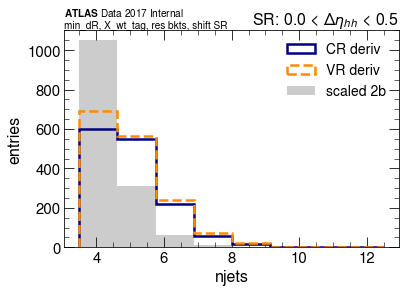

In [66]:
for i,eta_min, eta_max in zip(range(len(eta_edgs)),eta_edgs[:-1],eta_edgs[1:]):

    figDir = f'figures/data{yr}_sr_{x1}_{y1}/min_dR/'
    if not os.path.exists(figDir): os.mkdir(figDir)
    figDir += f'rwInclusive_deta_{eta_min}_{eta_max}/'
    if not os.path.exists(figDir): os.mkdir(figDir)
    
    for df,region in zip([sr,vr,cr],['SR','VR','CR']):

        mi = (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
        ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
        for c,n,r in zip(rw_cols,nBins,myRanges):

            plt.figure()

            # 4b  
            if region != 'SR':
                n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)

                xx = 0.5 * (e[1:]+e[:-1])
                plt.errorbar(xx, n_4b, np.sqrt(n_4b), color='k',label='4b',
                             marker='o',lw=0,elinewidth=2)

            # 2b trainings
            m_2b = mi & (df.ntag==2)

            n_2b_CR = plt.hist(df.loc[m_2b,c],n,r, label=f'CR deriv',
                               histtype='step',lw=2.5,color='navy',ls='-',
                               weights=df.loc[m_2b,'w_2b'],zorder=10)[0]
            n_2b_VR = plt.hist(df.loc[m_2b,c],n,r, label=f'VR deriv',
                               histtype='step',lw=2.5,color='darkorange',ls='--',
                               weights = df.loc[m_2b,'w_2b_VR'],zorder=10)[0]

            # Raw 2b scaled to 4b anticipation?
            raw_2b,e = np.histogram(df.loc[m_2b,c],n,r)
            if region == 'SR':
                xx = 0.5*(e[1:]+e[:-1])
                plt.hist(xx,e,color='grey',alpha=0.4,label='scaled 2b',
                         weights=raw_2b*np.sum(n_2b_CR)/np.sum(raw_2b))
            else:
                plt.hist(xx,e,color='grey',alpha=0.4,label='scaled 2b',
                         weights=raw_2b*np.sum(n_4b)/np.sum(raw_2b),zorder=0)

            plt.xlabel(c,fontsize=16)
            plt.ylabel('entries',fontsize=16)
            plt.legend()

            ax = plt.gca()
            plt.title(f'{region}: {ti}',loc='right',fontsize=16)
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

            ylim = plt.ylim()
            if 'HT' in c: plt.plot([300]*2,ylim,'k--')
            plt.ylim(ylim)   

            #plt.savefig(f'{figDir}/{c}_{region}.pdf',bbox_inches='tight')
            plt.show()

            
            break
        break
    break

Also - it's nice to have these plots for reference to show the rw *is* doing smth, but I think it's actually a little *confusing* to show grey curve as well haha.

**Question:** If I normalized *all* of these separately, how much variation would there be?

**Something Michael was curious about**

Difference b/w using the VR for the non-closure vs the VR derived systematic.

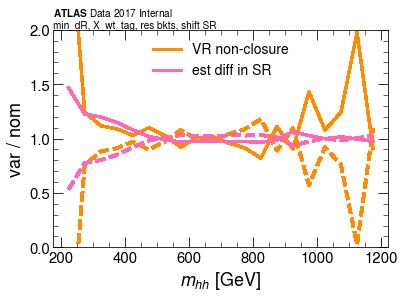

In [67]:
df = vr

vr_4b,e  = np.histogram(df.loc[df.ntag>=4,'m_hh'],20,(200,1200))
vr_cr = np.histogram(df.loc[df.ntag==2,'m_hh'],20,(200,1200),
                    weights=df.loc[df.ntag==2,'w_2b'])[0]

xx = 0.5 * (e[1:] + e[:-1])
plt.plot(xx,vr_4b/vr_cr,f'darkorange',label='VR non-closure')
plt.plot(xx,2-vr_4b/vr_cr,f'darkorange',ls='--')


df = sr
bmask = (df.ntag==2) & (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
b,e  = np.histogram(df.loc[bmask,'m_hh'],20,(200,1200),
                    weights=df.loc[bmask,'w_2b'])
b_vr = np.histogram(df.loc[bmask,'m_hh'],20,(200,1200),
                    weights=df.loc[bmask,'w_2b_VR'])[0]


plt.plot(xx,b_vr/b,f'hotpink',label='est diff in SR')
plt.plot(xx,2-b_vr/b,f'hotpink',ls='--')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('var / nom',fontsize=18)
ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.ylim(0,2)
plt.legend(loc='upper center')
plt.savefig('figures/data17_sr_124_117/min_dR/m_hh_VR_non_clos_vs_est_diff.pdf',
            bbox_inches='tight')
plt.show()

<ipython-input-68-098099371a24>:16: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,b_vr/b,f'C{i}',label=ti)
<ipython-input-68-098099371a24>:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-b_vr/b,f'C{i}',ls='--')
<ipython-input-68-098099371a24>:16: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,b_vr/b,f'C{i}',label=ti)
<ipython-input-68-098099371a24>:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-b_vr/b,f'C{i}',ls='--')
<ipython-input-68-098099371a24>:16: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,b_vr/b,f'C{i}',label=ti)
<ipython-input-68-098099371a24>:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-b_vr/b,f'C{i}',ls='--')


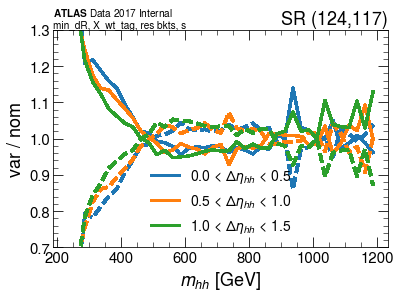

In [68]:
df = sr

for i,eta_min, eta_max in zip(range(len(eta_edgs)),eta_edgs[:-1],eta_edgs[1:]):

    ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
    
    bmask = (df.ntag==2) & (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
    
    
    b,e  = np.histogram(df.loc[bmask,'m_hh'],40,(200,1200),
                        weights=df.loc[bmask,'w_2b'])
    b_vr = np.histogram(df.loc[bmask,'m_hh'],40,(200,1200),
                        weights=df.loc[bmask,'w_2b_VR'])[0]

    xx = 0.5 * (e[1:] + e[:-1])
    plt.plot(xx,b_vr/b,f'C{i}',label=ti)
    plt.plot(xx,2-b_vr/b,f'C{i}',ls='--')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('var / nom',fontsize=18)
plt.title(f'SR (124,117)',loc='right')
ax = plt.gca()
plt.text(0,1,text[:-7],ha='left',va='bottom',fontsize=10,transform=ax.transAxes)


plt.legend()

plt.savefig('figures/data17_sr_124_117/min_dR/m_hh_shape_3_cats.pdf',bbox_inches='tight')

plt.ylim(0.7,1.3)
plt.savefig('figures/data17_sr_124_117/min_dR/m_hh_shape_3_cats_zoom.pdf',bbox_inches='tight')

plt.show()


**Take aways:**
1. I *don't* know if I trust the modelling at low $m_{hh}$
2. These systematics are *very* similar - I think it's at least worth a shot to try to decorrelate them.

In terms of trusting the low $m_{hh}$ modelling, the first thing that I could think to look at is the $t\bar{t}$ distribution.

**Let's also investigate the $t\bar{t}$ variation**

In [ ]:
mpl.rcParams.update({'figure.max_open_warning': 0})

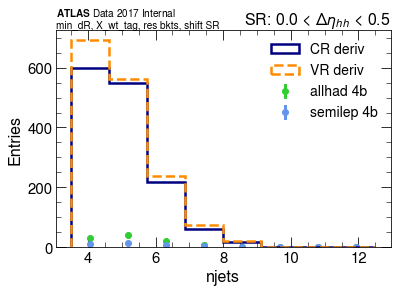

In [116]:
for eta_min, eta_max in zip(eta_edgs[:-1],eta_edgs[1:]):

    figDir = f'figures/data{yr}_sr_{x1}_{y1}/min_dR/'
    figDir += f'rwInclusive_ttbar_deta_{eta_min}_{eta_max}/'
    if not os.path.exists(figDir): os.mkdir(figDir)
    
    for i, df,region in zip(range(3),[sr,vr,cr],['SR','VR','CR']):

        mi = (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
        ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
        for c,n,r in zip(rw_cols,nBins,myRanges):
            
            plt.figure()
            # 4b  
            if region != 'SR':
                n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)

                xx = 0.5 * (e[1:]+e[:-1])
                plt.errorbar(xx, n_4b, np.sqrt(n_4b), color='k',label='4b',
                             marker='o',lw=0,elinewidth=2)

            # 2b trainings
            m_2b = mi & (df.ntag==2)

            n_2b_CR = plt.hist(df.loc[m_2b,c],n,r, label=f'CR deriv',
                               histtype='step',lw=2.5,color='navy',ls='-',
                               weights=df.loc[m_2b,'w_2b'],zorder=10)[0]
            n_2b_VR = plt.hist(df.loc[m_2b,c],n,r, label=f'VR deriv',
                               histtype='step',lw=2.5,color='darkorange',ls='--',
                               weights = df.loc[m_2b,'w_2b_VR'],zorder=10)[0]

            # ttbar
            for ps,dfi,color in zip(['allhad','semilep'],[ah,sl],['limegreen','cornflowerblue']):
                        
                m_4b = (dfi.dEta_hh > eta_min) & (dfi.dEta_hh < eta_max)
                m_4b = m_4b & (dfi.kinematic_region==i) & (dfi.ntag>=4)

                n_4b, e = np.histogram(dfi.loc[m_4b,c].values,n,r,
                                       weights=dfi.loc[m_4b,'mc_sf'].values)
                dn_4b = np.sqrt(np.histogram(dfi.loc[m_4b,c].values,n,r,
                                weights=dfi.loc[m_4b,'mc_sf'].values**2)[0])
                
                xx = 0.5 * (e[1:]+e[:-1])
                plt.errorbar(xx,n_4b,dn_4b,color=color,
                             marker='o',lw=0,elinewidth=3,label=f'{ps} 4b')

            plt.xlabel(c,fontsize=16)
            plt.ylabel('Entries',fontsize=16)
            plt.legend()

            ax = plt.gca()
            plt.title(f'{region}: {ti}',loc='right',fontsize=16)
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

            ylim = plt.ylim()
            if 'HT' in c: plt.plot([300]*2,ylim,'k--')
            plt.ylim(ylim)   

            plt.savefig(f'{figDir}/{c}_{region}.pdf',bbox_inches='tight')
            plt.show()

            break
        break
    break

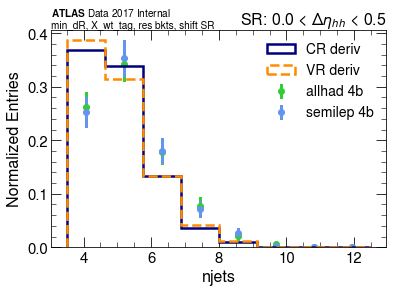

In [115]:
for eta_min, eta_max in zip(eta_edgs[:-1],eta_edgs[1:]):

    figDir = f'figures/data{yr}_sr_{x1}_{y1}/min_dR/'
    figDir += f'rwInclusive_ttbar_deta_{eta_min}_{eta_max}/'
    if not os.path.exists(figDir): os.mkdir(figDir)
    
    for i,df,region in zip(range(3),[sr,vr,cr],['SR','VR','CR']):

        mi = (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
        ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
        for c,n,r in zip(rw_cols,nBins,myRanges):

            #if c != 'm_hh': continue
            
            plt.figure()

            # 4b  
            if region != 'SR':
                n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)

                xx = 0.5 * (e[1:]+e[:-1])
                
                s = n / (np.sum(n_4b) * (r[1] - r[0]))
                
                plt.errorbar(xx, s*n_4b, s*np.sqrt(n_4b), color='k',label='4b',
                             marker='o',lw=0,elinewidth=2)

            # 2b trainings
            m_2b = mi & (df.ntag==2)

            n_2b_CR = plt.hist(df.loc[m_2b,c],n,r, label=f'CR deriv',density=True,
                               histtype='step',lw=2.5,color='navy',ls='-',
                               weights=df.loc[m_2b,'w_2b'],zorder=10)[0]
            n_2b_VR = plt.hist(df.loc[m_2b,c],n,r, label=f'VR deriv',density=True,
                               histtype='step',lw=2.5,color='darkorange',ls='--',
                               weights = df.loc[m_2b,'w_2b_VR'],zorder=10)[0]

            # ttbar
            for ps,dfi,color in zip(['allhad','semilep'],[ah,sl],['limegreen','cornflowerblue']):
                                        
                m_4b = (dfi.dEta_hh > eta_min) & (dfi.dEta_hh < eta_max)
                m_4b = m_4b & (dfi.kinematic_region==i) & (dfi.ntag>=4)
                              
                n_4b, e = np.histogram(dfi.loc[m_4b,c].values,n,r,
                                       weights=dfi.loc[m_4b,'mc_sf'].values)
                dn_4b = np.sqrt(np.histogram(dfi.loc[m_4b,c].values,n,r,
                                weights=dfi.loc[m_4b,'mc_sf'].values**2)[0])
                
                xx = 0.5 * (e[1:]+e[:-1])
                s = n / (np.sum(n_4b) * (r[1] - r[0]))
                plt.errorbar(xx,s*n_4b,s*dn_4b,color=color,
                             marker='o',lw=0,elinewidth=3,label=f'{ps} 4b')

            plt.xlabel(c,fontsize=16)
            plt.ylabel('Normalized Entries',fontsize=16)
            plt.legend()

            ax = plt.gca()
            plt.title(f'{region}: {ti}',loc='right',fontsize=16)
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

            ylim = plt.ylim()
            if 'HT' in c: plt.plot([300]*2,ylim,'k--')
            plt.ylim(ylim)   

            plt.savefig(f'{figDir}/{c}_norm_{region}.pdf',bbox_inches='tight')
            plt.show()

            break
        break
    break

Ok, so it seems like what I'm looking at right now is that $t\bar{t}$ is not having as much of a contribution as I was thinking, a.k.a, it's probably not accounting  for the non-closure.

It's probably reasonable to compare the non-closure in the VR to $t\bar{t}$ distributions (w/ the associated error bar overlaid)

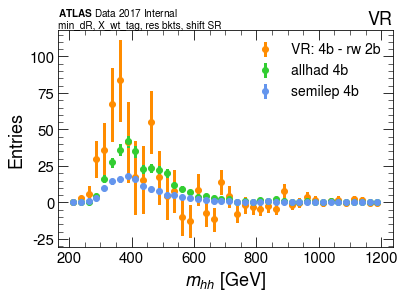

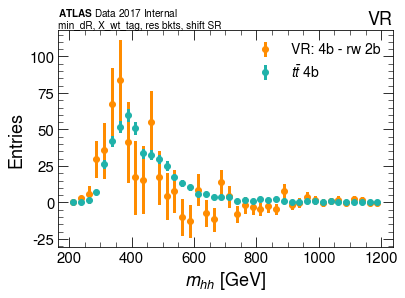

In [120]:
n, r = 40, (200,1200)

df = vr
i = 1

vr_4b,e  = np.histogram(df.loc[df.ntag>=4,'m_hh'],n,r)
vr_cr = np.histogram(df.loc[df.ntag==2,'m_hh'],n,r,
                    weights=df.loc[df.ntag==2,'w_2b'])[0]

xx = 0.5 * (e[1:] + e[:-1])
plt.errorbar(xx, vr_4b-vr_cr, np.sqrt(vr_4b), color='darkorange', 
             label='VR: 4b - rw 2b', marker='o',lw=0,elinewidth=3)

# ttbar
ns = []
dns = []
for ps,dfi,color in zip(['allhad','semilep'],[ah,sl],['limegreen','cornflowerblue']):

    m_4b = (dfi.kinematic_region==i) & (dfi.ntag>=4)

    n_4b, e = np.histogram(dfi.loc[m_4b,'m_hh'].values,n,r,
                           weights=dfi.loc[m_4b,'mc_sf'].values)
    dn_4b = np.sqrt(np.histogram(dfi.loc[m_4b,'m_hh'].values,n,r,
                    weights=dfi.loc[m_4b,'mc_sf'].values**2)[0])

    plt.errorbar(xx,n_4b,dn_4b,color=color,
                 marker='o',lw=0,elinewidth=3,label=f'{ps} 4b')
    ns.append(n_4b)
    dns.append(dn_4b)
    
plt.legend(loc='upper right')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(f'VR',loc='right')
ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'figures/data{yr}_sr_124_117/min_dR/m_hh_VR_non_clos_vs_ttbar.pdf', bbox_inches='tight')


# Next - make the *smae plot* but w/ the ttbar components added up and overlaid
plt.figure()
plt.errorbar(xx, vr_4b-vr_cr, np.sqrt(vr_4b), color='darkorange', 
             label='VR: 4b - rw 2b', marker='o',lw=0,elinewidth=3)

n_4b = ns[0] + ns[1]
dn_4b = np.sqrt(dns[0]**2 + dns[1]**2)

plt.errorbar(xx,n_4b,dn_4b,color='lightseagreen',
              marker='o',lw=0,elinewidth=3,label=r'$t\bar{t}$ 4b')
plt.legend(loc='upper right')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(f'VR',loc='right')
ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'figures/data{yr}_sr_124_117/min_dR/m_hh_VR_non_clos_vs_incl_ttbar.pdf', bbox_inches='tight')

plt.show()

**Conclusion:** It's not 100% clear if the non-closure is coming from $t\bar{t}$ rn.

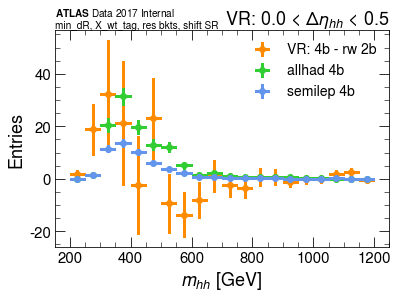

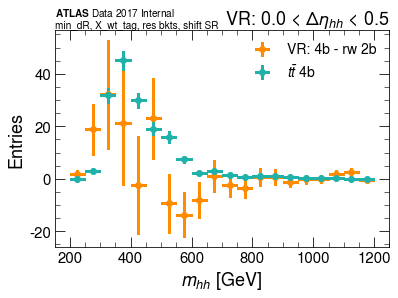

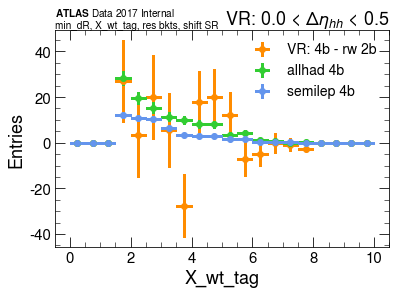

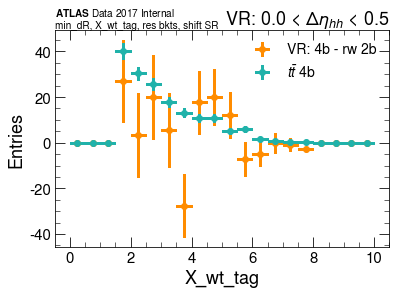

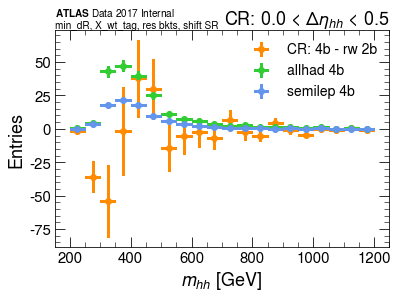

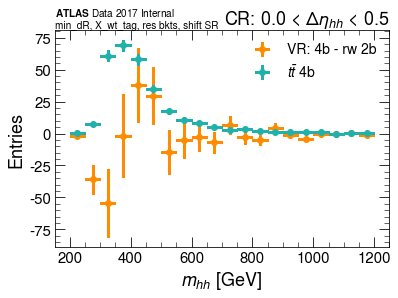

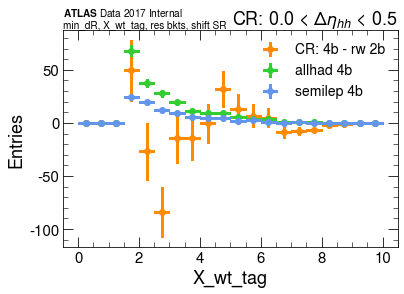

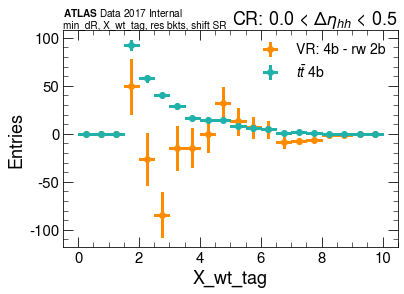

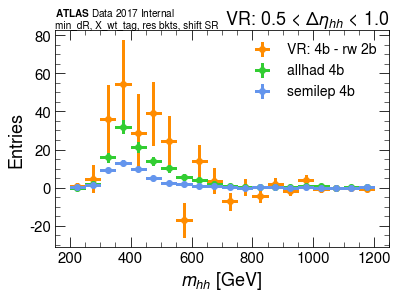

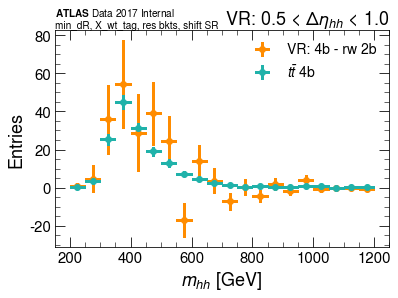

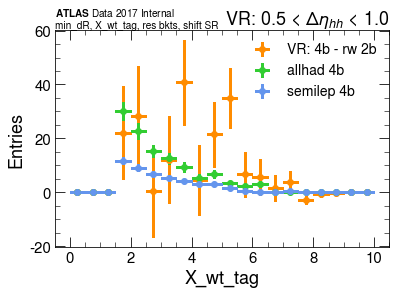

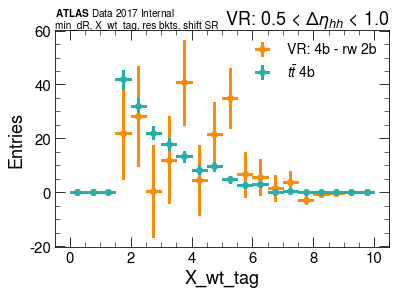

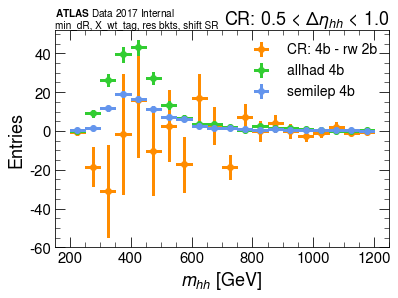

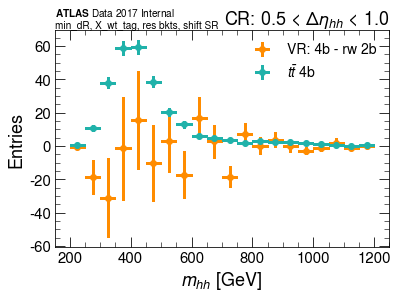

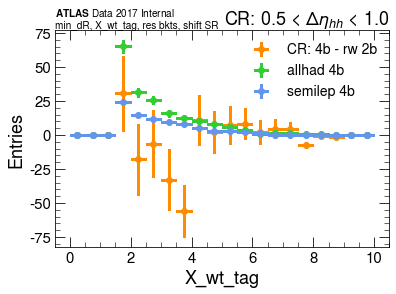

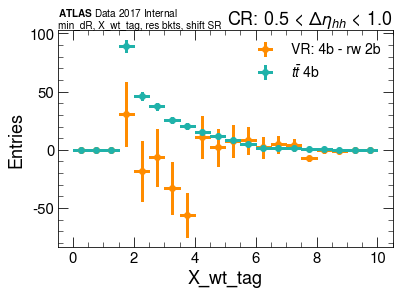

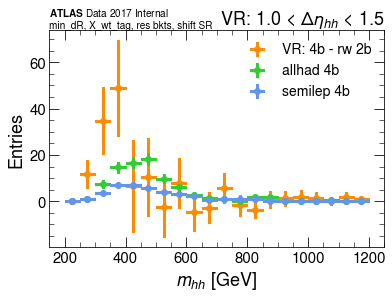

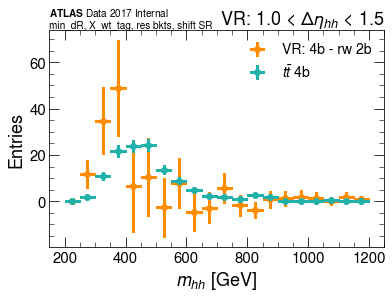

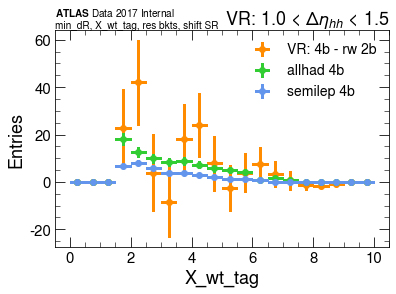

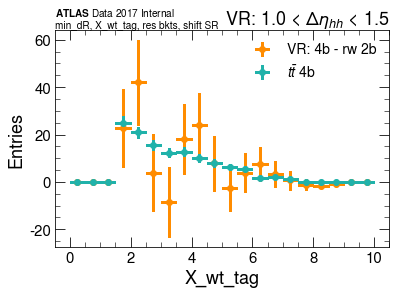

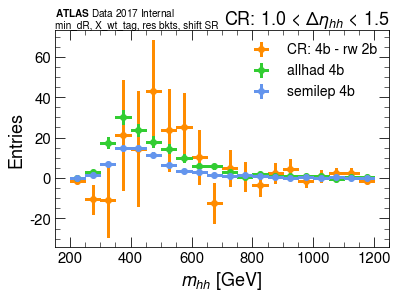

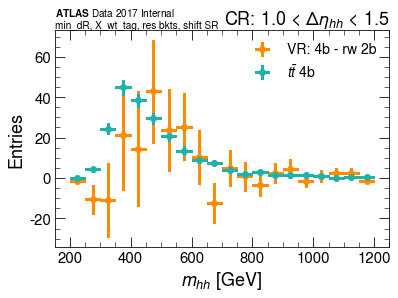

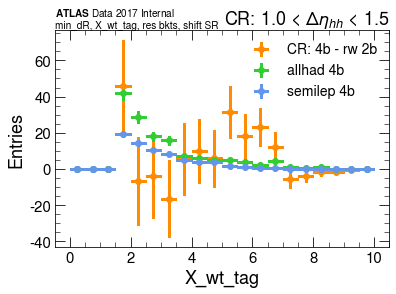

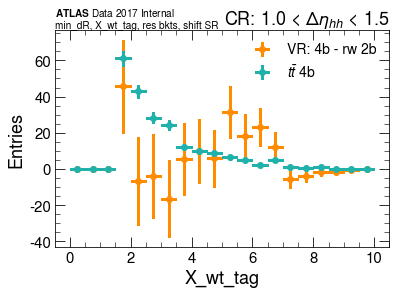

In [125]:
for eta_min, eta_max in zip(eta_edgs[:-1],eta_edgs[1:]):

    figDir = f'figures/data{yr}_sr_{x1}_{y1}/min_dR/'
    figDir += f'rwInclusive_ttbar_deta_{eta_min}_{eta_max}/'
    
    for df,i,region in zip([vr,cr],[1,2],['VR','CR']):
    
        mi = (df.dEta_hh > eta_min) & (df.dEta_hh < eta_max) 
        ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'

        for c,n,r,xl in zip(['m_hh','X_wt_tag'],[20]*2,[(200,1200),(0,10)],['$m_{hh}$ [GeV]','X_wt_tag']):

            dx = 0.5 * (r[1]-r[0])/n
            
            plt.figure()
            vr_4b,e  = np.histogram(df.loc[mi&(df.ntag>=4),c],n,r)
            vr_cr = np.histogram(df.loc[mi&(df.ntag==2),c],n,r,
                                weights=df.loc[mi&(df.ntag==2),'w_2b'])[0]

            xx = 0.5 * (e[1:] + e[:-1])
            plt.errorbar(xx, vr_4b-vr_cr, np.sqrt(vr_4b), dx, color='darkorange', 
                         label=f'{region}: 4b - rw 2b', marker='o',lw=0,elinewidth=3)

            # ttbar
            ns = []
            dns = []
            for ps,dfi,color in zip(['allhad','semilep'],[ah,sl],['limegreen','cornflowerblue']):

                m_4b = (dfi.dEta_hh > eta_min) & (dfi.dEta_hh < eta_max)
                m_4b = m_4b & (dfi.kinematic_region==i) & (dfi.ntag>=4)

                n_4b, e = np.histogram(dfi.loc[m_4b,c].values,n,r,
                                       weights=dfi.loc[m_4b,'mc_sf'].values)
                dn_4b = np.sqrt(np.histogram(dfi.loc[m_4b,c].values,n,r,
                                weights=dfi.loc[m_4b,'mc_sf'].values**2)[0])

                plt.errorbar(xx,n_4b,dn_4b,dx,color=color,
                             marker='o',lw=0,elinewidth=3,label=f'{ps} 4b')
                
                ns.append(n_4b)
                dns.append(dn_4b)
                
            plt.legend(loc='upper right')

            plt.xlabel(xl,fontsize=18)
            plt.ylabel('Entries',fontsize=18)
            plt.title(f'{region}: {ti}',loc='right')
            ax = plt.gca()
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

            plt.savefig(f'{figDir}/{c}_{region}_non_clos_vs_ttbar.pdf', bbox_inches='tight')
            
            
            plt.figure()
            plt.errorbar(xx, vr_4b-vr_cr, np.sqrt(vr_4b), dx,color='darkorange', 
                         label='VR: 4b - rw 2b', marker='o',lw=0,elinewidth=3)

            n_4b = ns[0] + ns[1]
            dn_4b = np.sqrt(dns[0]**2 + dns[1]**2)

            plt.errorbar(xx,n_4b,dn_4b,dx,color='lightseagreen',
                          marker='o',lw=0,elinewidth=3,label=r'$t\bar{t}$ 4b')
            plt.legend(loc='upper right')

            plt.xlabel(xl,fontsize=18)
            plt.ylabel('Entries',fontsize=18)
            plt.title(f'{region}: {ti}',loc='right')
            ax = plt.gca()
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

            plt.savefig(f'{figDir}/{c}_{region}_non_clos_vs_incl_ttbar.pdf', bbox_inches='tight')
            
    plt.show()

**Next check:** How do the bootstrap and shape variations compare?

In [85]:
shapeDir = f'figures/data{yr}_sr_{x1}_{y1}/min_dR/systsParm'
if not os.path.exists(shapeDir): os.mkdir(shapeDir)

In [89]:
len(e)

41

<ipython-input-90-7fb01f6d333a>:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-90-7fb01f6d333a>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-90-7fb01f6d333a>:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-90-7fb01f6d333a>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-90-7fb01f6d333a>:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-90-7fb01f6d333a>:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-90-7fb01f6d333a>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,


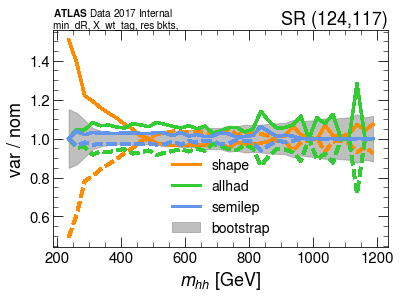

In [90]:
n,r = 40, (200,1200)

nom,e = np.histogram(sr.loc[sr.ntag==2,'m_hh'],n,r, weights=sr.loc[sr.ntag==2,'w_2b'])
var,_ = np.histogram(sr.loc[sr.ntag==2,'m_hh'],n,r, weights=sr.loc[sr.ntag==2,'w_2b_VR'])

n_ah = np.histogram(ah.loc[(ah.ntag>=4)&(ah.kinematic_region==0),'m_hh'],n,r,
                    weights=ah.loc[(ah.ntag>=4)&(ah.kinematic_region==0),'mc_sf'])[0]
n_sl = np.histogram(sl.loc[(sl.ntag>=4)&(sl.kinematic_region==0),'m_hh'],n,r, 
                    weights=sl.loc[(sl.ntag>=4)&(sl.kinematic_region==0),'mc_sf'])[0]

bs = calc_bstrap(sr, 'm_hh', yr, norm, norm_IQR, e)

xx = 0.5 * (e[1:]+e[:-1])

for v,l,c in zip([var,nom+n_ah,nom+n_sl],['shape','allhad','semilep'],
                 ['darkorange','limegreen','cornflowerblue']):

    plt.plot(xx,v/nom,color=c,label=l)
    plt.plot(xx,2-v/nom,color=c,ls='--')

plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,
                 label='bootstrap')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('var / nom',fontsize=18)
plt.title(f'SR (124,117)',loc='right')
ax = plt.gca()
plt.text(0,1,text[:-9],ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.legend()

plt.savefig(f'{shapeDir}/m_hh_SR_bkg_systs_ttbar.pdf',bbox_inches='tight')

plt.show()

I don't know if this is the right thing to do, but it *does* seem like a reasonable thing to do haha.

<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:25: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,


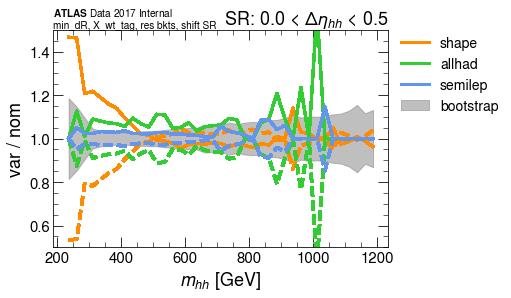

<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:25: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,


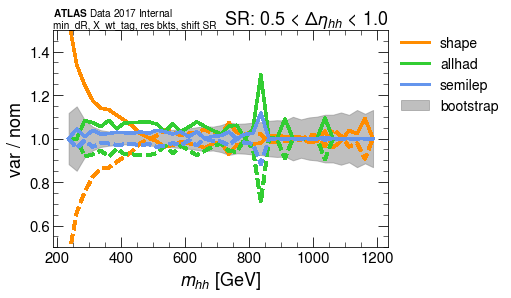

<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,v/nom,color=c,label=l)
<ipython-input-93-ccdd15a158f4>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-v/nom,color=c,ls='--')
<ipython-input-93-ccdd15a158f4>:25: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,


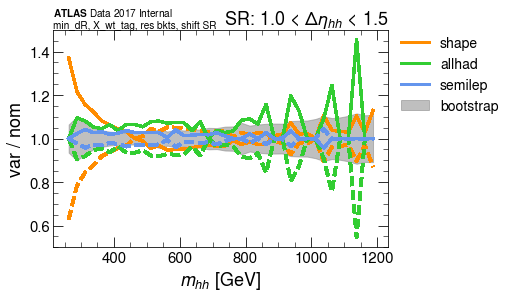

In [93]:
n, r = 40, (200,1200)

for eta_min, eta_max in zip(eta_edgs[:-1],eta_edgs[1:]):

    mi = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max) & (sr.ntag==2)
    ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
    
    nom,e = np.histogram(sr.loc[mi,'m_hh'],n,r, weights=sr.loc[mi,'w_2b'])
    var,_ = np.histogram(sr.loc[mi,'m_hh'],n,r, weights=sr.loc[mi,'w_2b_VR'])

    m_ah = (ah.dEta_hh > eta_min) & (ah.dEta_hh < eta_max) & (ah.kinematic_region==0) & (ah.ntag>=4)
    m_sl = (sl.dEta_hh > eta_min) & (sl.dEta_hh < eta_max) & (sl.kinematic_region==0) & (sl.ntag>=4)
    
    n_ah = np.histogram(ah.loc[m_ah,'m_hh'],n,r,weights=ah.loc[m_ah,'mc_sf'])[0]
    n_sl = np.histogram(sl.loc[m_sl,'m_hh'],n,r,weights=sl.loc[m_sl,'mc_sf'])[0]

    bs = calc_bstrap(sr[mi], 'm_hh', yr, norm,norm_IQR, e)
    
    for v,l,c in zip([var,nom+n_ah,nom+n_sl],['shape','allhad','semilep'],
                     ['darkorange','limegreen','cornflowerblue']):

        plt.plot(xx,v/nom,color=c,label=l)
        plt.plot(xx,2-v/nom,color=c,ls='--')

    plt.fill_between(xx,1-bs/nom,1+bs/nom,color='grey',alpha=0.5,
                     label='bootstrap')

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('var / nom',fontsize=18)
    plt.title(f'SR: {ti}',loc='right')
    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

    plt.legend(bbox_to_anchor=(1,1.03))
    plt.ylim(0.5,1.5)
    
    plt.savefig(f'{shapeDir}/m_hh_SR_bkg_systs_ttbar_dEta_hh_{eta_min}_{eta_max}.pdf',bbox_inches='tight')

    plt.show()
    
    

Let's *just* compare the bootstrap contributions!!

<ipython-input-95-e16cf0517be0>:12: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1-bs/nom,color=f'C{i}',ls='dotted',label=ti)
<ipython-input-95-e16cf0517be0>:13: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1+bs/nom,color=f'C{i}',ls='dotted')
<ipython-input-95-e16cf0517be0>:12: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1-bs/nom,color=f'C{i}',ls='dotted',label=ti)
<ipython-input-95-e16cf0517be0>:13: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1+bs/nom,color=f'C{i}',ls='dotted')
<ipython-input-95-e16cf0517be0>:12: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1-bs/nom,color=f'C{i}',ls='dotted',label=ti)
<ipython-input-95-e16cf0517be0>:13: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,1+bs/nom,color=f'C{i}',ls='dotted')


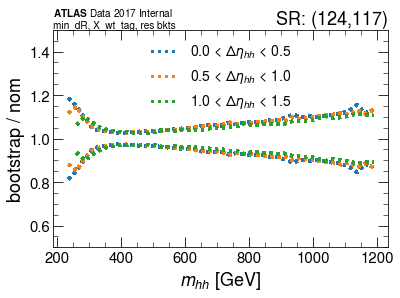

In [95]:
n, r = 40, (200,1200)

for i,eta_min, eta_max in zip(range(3),eta_edgs[:-1],eta_edgs[1:]):

    mi = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max) & (sr.ntag==2)
    ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
    
    nom,e = np.histogram(sr.loc[mi,'m_hh'],n,r, weights=sr.loc[mi,'w_2b'])

    bs = calc_bstrap(sr[mi], 'm_hh', yr, norm, norm_IQR, e)
    
    plt.plot(xx,1-bs/nom,color=f'C{i}',ls='dotted',label=ti)
    plt.plot(xx,1+bs/nom,color=f'C{i}',ls='dotted')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('bootstrap / nom',fontsize=18)
plt.title(f'SR: ({x1},{y1})',loc='right')
ax = plt.gca()
plt.text(0,1,text[:-10],ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.legend(loc='upper center')
plt.ylim(0.5,1.5)

plt.savefig(f'{shapeDir}/m_hh_SR_bootstraps_3_cats.pdf',bbox_inches='tight')

plt.show()

**Question:** How correlated is the all hadronic template with our signal?

In [97]:
scols = ['m_hh','m_h1','m_h2','mc_sf','dEta_hh','X_wt','ntag','pass_vbf_sel','truth_mhh']

sFile = f'../data/RR/NNT_DEC20_MDR_VEC/MC/600043_{mc}/NanoNTuple.root'
tName = 'fullmassplane'
try:
    sdf = uproot.open(sFile)[tName].pandas.df(scols)
except:
    sdf = uproot.open(sFile)[tName].arrays(scols,library='pd')
    
# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
sdf['mc_sf']     *= L[yr]
sdf['truth_mhh'] *= 0.001

sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

sdf = sdf[(sdf.Xhh_new < 1.6) & (sdf.ntag>=4) & (~sdf.pass_vbf_sel)]


<ipython-input-98-6e90bcbeb158>:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-98-6e90bcbeb158>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-98-6e90bcbeb158>:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-98-6e90bcbeb158>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-98-6e90bcbeb158>:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-98-6e90bcbeb158>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')


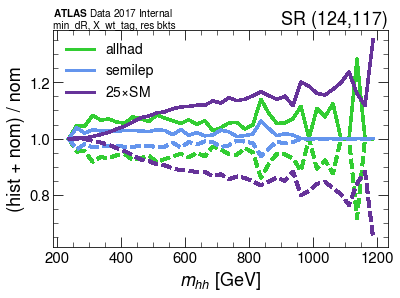

In [98]:
n,r = 40, (200,1200)

nom,e = np.histogram(sr.loc[sr.ntag==2,'m_hh'],n,r, weights=sr.loc[sr.ntag==2,'w_2b'])
var,_ = np.histogram(sr.loc[sr.ntag==2,'m_hh'],n,r, weights=sr.loc[sr.ntag==2,'w_2b_VR'])

xx = 0.5 * (e[1:]+e[:-1])

n_ah = np.histogram(ah.loc[(ah.ntag>=4)&(ah.kinematic_region==0),'m_hh'],n,r,
                    weights=ah.loc[(ah.ntag>=4)&(ah.kinematic_region==0),'mc_sf'])[0]

n_sl = np.histogram(sl.loc[(sl.ntag>=4)&(sl.kinematic_region==0),'m_hh'],n,r, 
                    weights=sl.loc[(sl.ntag>=4)&(sl.kinematic_region==0),'mc_sf'])[0]


s = np.histogram(sdf.m_hh,n,r, weights=sdf.mc_sf)[0]

for ni,l,c in zip([n_ah,n_sl,25*s],['allhad','semilep',r'25$\times$SM'],
                  ['limegreen','cornflowerblue','rebeccapurple']):

    plt.plot(xx,(ni+nom)/nom,color=c,label=l)
    plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('(hist + nom) / nom',fontsize=18)
plt.title(f'SR (124,117)',loc='right')
ax = plt.gca()
plt.text(0,1,text[:-10],ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.legend()

plt.savefig(f'{shapeDir}/m_hh_SR_sig_ttbar.pdf',bbox_inches='tight')

plt.show()

<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')


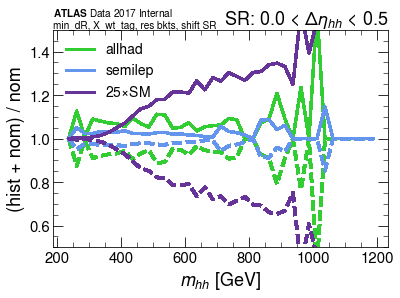

<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')


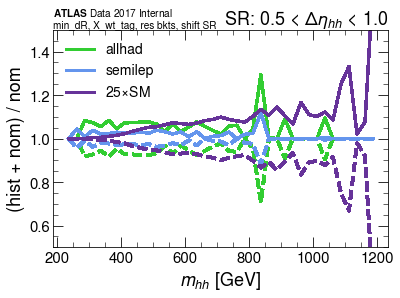

<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
<ipython-input-99-033ffd88fa85>:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,(ni+nom)/nom,color=c,label=l)
<ipython-input-99-033ffd88fa85>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')


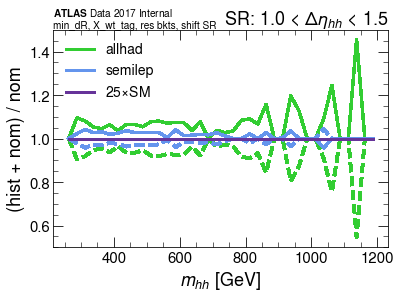

In [99]:
n, r = 40, (200,1200)

for eta_min, eta_max in zip(eta_edgs[:-1],eta_edgs[1:]):

    mi = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max) & (sr.ntag==2)
    ti = f'{eta_min} < '+'$\Delta \eta_{hh}$'+f' < {eta_max}'
    
    nom,e = np.histogram(sr.loc[mi,'m_hh'],n,r, weights=sr.loc[mi,'w_2b'])
    
    m_ah = (ah.dEta_hh > eta_min) & (ah.dEta_hh < eta_max) & (ah.kinematic_region==0) & (ah.ntag>=4)
    m_sl = (sl.dEta_hh > eta_min) & (sl.dEta_hh < eta_max) & (sl.kinematic_region==0) & (sl.ntag>=4)
    
    n_ah = np.histogram(ah.loc[m_ah,'m_hh'],n,r,weights=ah.loc[m_ah,'mc_sf'])[0]
    n_sl = np.histogram(sl.loc[m_sl,'m_hh'],n,r,weights=sl.loc[m_sl,'mc_sf'])[0]

    m_sig = (sdf.dEta_hh > eta_min) & (sdf.dEta_hh > eta_max)
    s = np.histogram(sdf.loc[m_sig,'m_hh'],n,r,weights=sdf.loc[m_sig,'mc_sf'])[0]
    
    for ni,l,c in zip([n_ah,n_sl,25*s],['allhad','semilep',r'25$\times$SM'],
                      ['limegreen','cornflowerblue','rebeccapurple']):

        plt.plot(xx,(ni+nom)/nom,color=c,label=l)
        plt.plot(xx,2-(ni+nom)/nom,color=c,ls='--')
    
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('(hist + nom) / nom',fontsize=18)
    plt.title(f'SR: {ti}',loc='right')
    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

    plt.legend()
    plt.ylim(0.5,1.5)
    
    plt.savefig(f'{shapeDir}/m_hh_SR_sig_ttbar_dEta_hh_{eta_min}_{eta_max}.pdf',bbox_inches='tight')

    plt.show()

**Let's visualize the shape systematic in 2d!!**

(For now, I'm going to try 12 bins to see the *variation* even if I don't want to use as many @ the end of the day.)

In [100]:
b_cr,ex,ey = np.histogram2d(*sr.loc[sr.ntag==2,['m_hh','dEta_hh']].values.T,
                            [40,12],[[200,1200],[0,1.5]],
                            weights=sr.loc[sr.ntag==2,'w_2b'].values)

In [101]:
b_vr,ex,ey = np.histogram2d(*sr.loc[sr.ntag==2,['m_hh','dEta_hh']].values.T,
                            [40,12],[[200,1200],[0,1.5]],
                            weights=sr.loc[sr.ntag==2,'w_2b_VR'].values)

In [102]:
b_vr[5,5]

46.02771660106146

In [103]:
b_cr[5,5]

39.78525509159139

<ipython-input-104-16913d0d1e1a>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((b_vr/b_cr).T,cmap='YlGnBu',origin='lower')


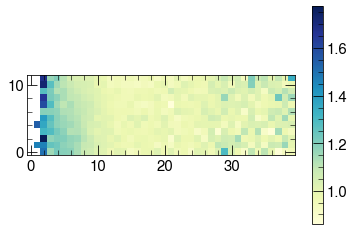

In [104]:
plt.imshow((b_vr/b_cr).T,cmap='YlGnBu',origin='lower')
plt.colorbar()

In [105]:
xx = 0.5*(ex[1:]+ex[:-1])
yy = 0.5*(ey[1:]+ey[:-1])

z = b_vr/b_cr

<ipython-input-105-557d915e894f>:4: RuntimeWarning: invalid value encountered in true_divide
  z = b_vr/b_cr


In [106]:
x,y = np.meshgrid(xx,yy)

In [107]:
dx = (ex[1] - ex[0] )#/2
dy = (ey[1] - ey[0] )#/2

In [108]:
from mpl_toolkits import mplot3d

In [109]:
X = x.ravel()
Y = y.ravel()
Z = z.ravel()

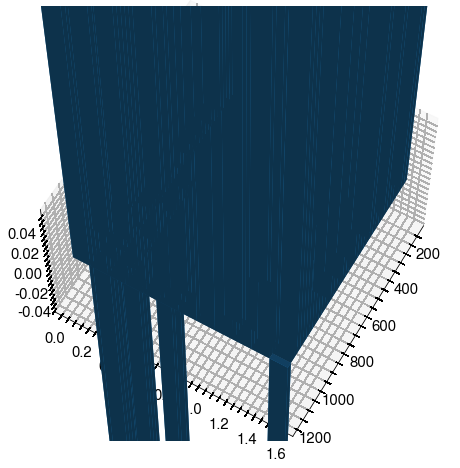

In [110]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


ax.bar3d( x.ravel(),
          y.ravel(),
          np.zeros_like(z.ravel()),
          dx, dy, z.ravel() ,cmap='hsv')


#ax.scatter(x,y,z.T,s=100,c='b',cmap='YlGnBu')
# ax.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
# ax.set_ylabel('$m_{h1}$ [GeV]',fontsize=15)
# ax.set_zlabel('parabaloid predicted $\sigma$',fontsize=15)

ax.view_init(60, 30)

#plt.savefig('figures/interp2/toy_sigma_2b.pdf',bbox_inches='tight')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

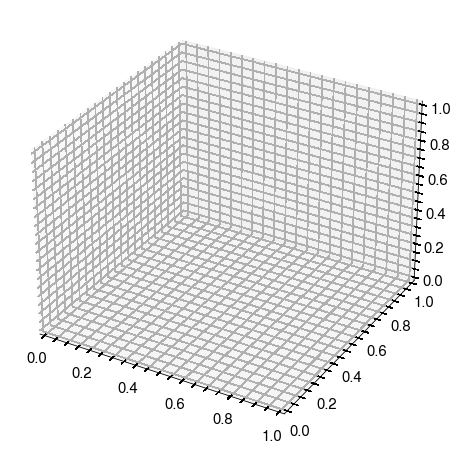

In [111]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(X,Y,Z,s=100,c='b',cmap='YlGnBu')
ax.plot_wireframe(x,y,z,s=100,c='b',cmap='YlGnBu')


ax.set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_ylabel('$m_{h1}$ [GeV]',fontsize=15)
ax.set_zlabel('var / nom',fontsize=15)

ax.view_init(60, 30)

#plt.savefig('figures/interp2/toy_sigma_2b.pdf',bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib import cm

In [ ]:

x = sr.loc[sr.ntag==2,'m_hh'].values
y = sr.loc[sr.ntag==2,'dEta_hh'].values

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
b_cr, xedges, yedges = np.histogram2d(x, y, [40,12], [[200,1200],[0,1.5]], 
                                      weights=sr.loc[sr.ntag==2,'w_2b'].values)
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = b_cr.T.flatten()

cmap = cm.get_cmap('Purples') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("CR derived est")
plt.xlabel("$m_{hh}$")
plt.ylabel("$\Delta \eta_{hh}$")
#plt.savefig("Your_title_goes_here")
plt.show()

In [ ]:

x = sr.loc[sr.ntag==2,'m_hh'].values
y = sr.loc[sr.ntag==2,'dEta_hh'].values

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
b_vr, xedges, yedges = np.histogram2d(x, y, [40,12], [[200,1200],[0,1.5]], 
                                      weights=sr.loc[sr.ntag==2,'w_2b_VR'].values)
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = b_vr.T.flatten()

cmap = cm.get_cmap('Oranges') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("CR derived est")
plt.xlabel("$m_{hh}$")
plt.ylabel("$\Delta \eta_{hh}$")
#plt.savefig("Your_title_goes_here")
plt.show()

In [ ]:

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

dz = (b_vr / b_cr).T.flatten()

cmap = cm.get_cmap('PuOr') 
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

plt.title("CR derived est")
plt.xlabel("$m_{hh}$")
plt.ylabel("$\Delta \eta_{hh}$")
#plt.savefig("Your_title_goes_here")
plt.show()

Honestly - I think 3d plots would be nice - but 

Check hpScans-rnvp-5vars rn!!

In [112]:
fig = go.Figure(data=[go.Scatter3d(
    x=hh,
    y=np.log10(bb),
    z=ll,
    text=srLoss,
    mode='markers',
    marker=dict(
        size=12,
        showscale = True,
        color=srLoss, # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.8, colorbar = dict(thickness=20)
    ),
)])

fig.update_layout(
    scene = dict(
                  xaxis = dict(title='hidden dimension'),
                  yaxis = dict(title='log10(weight decay)'),
                  zaxis = dict(title='# of flow layers')),
    title_text = 'R-NVP: 2-vars scan', height = 500)


fig.update_yaxes(type="log")

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

NameError: name 'go' is not defined

**Eigen decomposition**